In [39]:
#!/usr/bin/python3.8.10
# -*- coding: UTF-8 -*-
"""
Plot a single figure
"""

import sys
from typing import List, Dict
import matplotlib.pyplot as plt
import numpy as np

# Parameters for scenarios
exp_path = "/home/rdaneel/MHCBS/local/hwy_data/"
map_name = "warehouse-10-20-10-2-1"
scen_name = "s2s"
scen_num = 1
ag_num = 600
hwy_name = "Human" # "GPBS-1.2"
solvers = [
    "EECBS-BP-WDG",
    "EECBS-FX-BP-WDG",
    # "EECBS-BP-WDG-HWY-Human",
    # "EECBS-FX-BP-WDG-HWY-Human",
    "EECBS-BP-WDG-HWY",
    "EECBS-FX-BP-WDG-HWY",
    # "GPBS-1.2",
]

solvers_without_lb = ["GPBS-1.2", "TrafficFlow"]

# Parameters for plotting
font_size = 18
solver_colors = {
    "EECBS-BP-WDG": "grey",
    # "EECBS-BP-WDG-HWY": "magenta", # "deepskyblue",
    "EECBS-BP-WDG-HWY": "deepskyblue",
    "EECBS-FX-BP-WDG-HWY": "red",
    # "EECBS-FX-BP-WDG-HWY": "brown", # red
    "GPBS-1.2": "orange",
    "EECBS-FX-BP-WDG": "purple"
}
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150


In [40]:
# Load data
max_agent_num = 0
all_paths:Dict[str, Dict[str, Dict[int, Dict]]] = {}
for solver in solvers:
    path_csv = exp_path + hwy_name + "/" + map_name + "/" + scen_name + "-" + str(scen_num) + \
        "/ag-" + str(ag_num) + "/paths_" + solver + ".csv"
    paths = {"width": 0, "soc": 0, "solb": 0, "paths":{}}
    with open(path_csv, mode='r', encoding='utf-8') as fin:
        print("Open: ", path_csv)
        line = fin.readline().strip().split(',')
        assert line[0] == "width"
        paths["width"] = int(line[1])

        line = fin.readline().strip().split(',')
        assert line[0] == "soc"
        paths["soc"] = int(line[1])

        line = fin.readline().strip().split(',')
        assert line[0] == "solb"
        paths["solb"] = int(line[1])

        for line in fin.readlines():
            line = line.strip().split(',')
            ag_id = int(line[0])
            cost = int(line[1])
            lb = int(line[2])
            path = []
            for t in range(3, len(line)):
                path.append(int(line[t]))
            assert len(path) == cost + 1
            paths["paths"][ag_id] = {"cost": cost, "lb": lb, "path": path}
    all_paths[solver] = paths
    max_agent_num = max(max_agent_num, len(paths["paths"]))


Open:  /home/rdaneel/MHCBS/local/hwy_data/Human/warehouse-10-20-10-2-1/s2s-1/ag-600/paths_EECBS-BP-WDG.csv
Open:  /home/rdaneel/MHCBS/local/hwy_data/Human/warehouse-10-20-10-2-1/s2s-1/ag-600/paths_EECBS-FX-BP-WDG.csv
Open:  /home/rdaneel/MHCBS/local/hwy_data/Human/warehouse-10-20-10-2-1/s2s-1/ag-600/paths_EECBS-BP-WDG-HWY.csv
Open:  /home/rdaneel/MHCBS/local/hwy_data/Human/warehouse-10-20-10-2-1/s2s-1/ag-600/paths_EECBS-FX-BP-WDG-HWY.csv


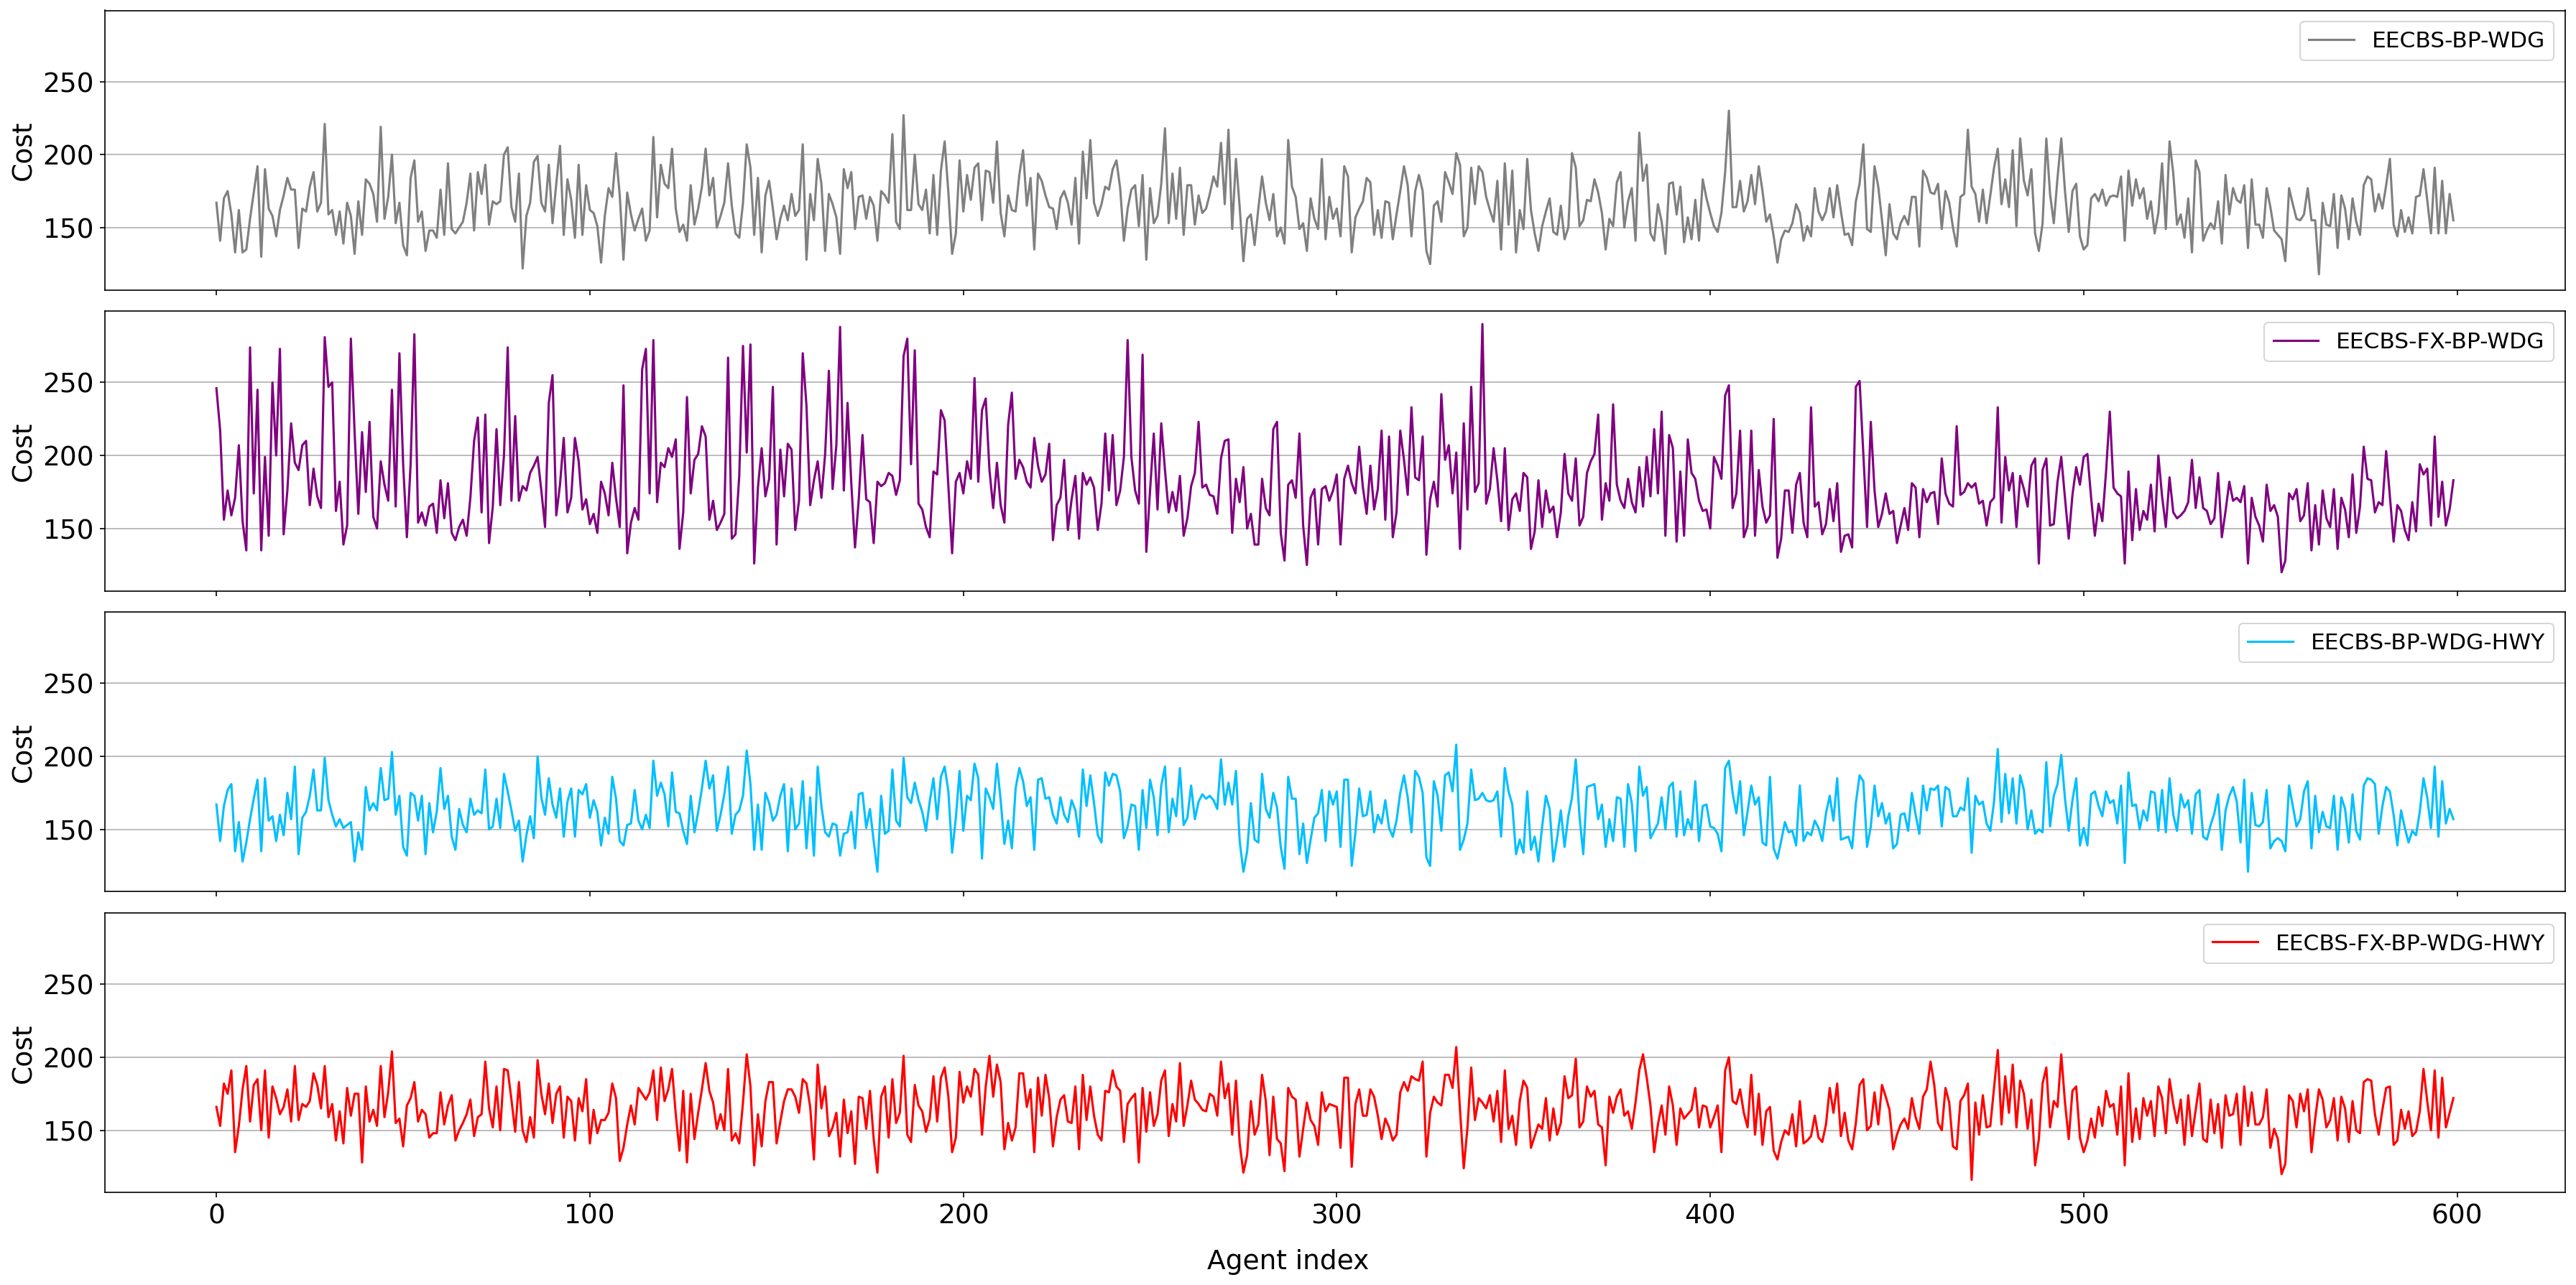

In [41]:
# Plot costs
costs:Dict[str,List[int]] = {}
lowerbounds:Dict[str,List[int]] = {}
for solver in solvers:
    if solver not in all_paths or solver not in all_paths:
        continue
    cost = [np.inf for _ in range(max_agent_num)]
    lb   = [np.inf for _ in range(max_agent_num)]
    for (ag_id, path) in all_paths[solver]["paths"].items():
        cost[ag_id] = all_paths[solver]["paths"][ag_id]["cost"]
        lb[ag_id] = all_paths[solver]["paths"][ag_id]["lb"]
    costs[solver] = cost
    lowerbounds[solver] = lb

if len(costs) == 0:
    sys.exit("No values involve")

fig, axs = plt.subplots(len(costs), figsize=(24,3*len(costs)), sharex=True, sharey=True)
for fidx, (solver, cost) in enumerate(costs.items()):
    if len(costs) == 1:
        cur_axs = axs
    else:
        cur_axs = axs[fidx]
    cur_axs.plot(
        list(range(len(cost))),
        cost,
        label=solver,
        color=solver_colors[solver]
    )

    # color_val = colors.to_rgba(solver_colors[solver])
    # new_color = (color_val[0], color_val[1], color_val[2], color_val[3] * 0.5)
    # cur_axs.plot(
    #     list(range(len(lowerbounds[solver]))),
    #     lowerbounds[solver],
    #     color=new_color
    # )

    cur_axs.legend(fontsize=font_size//1.2)
    cur_axs.grid(axis="y")
    cur_axs.tick_params(axis='y', labelsize=font_size)
    cur_axs.set_ylabel("Cost", fontsize=font_size)
    # cur_axs.set_ylim(top=300)

fig.supxlabel("Agent index", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tight_layout()
plt.show()

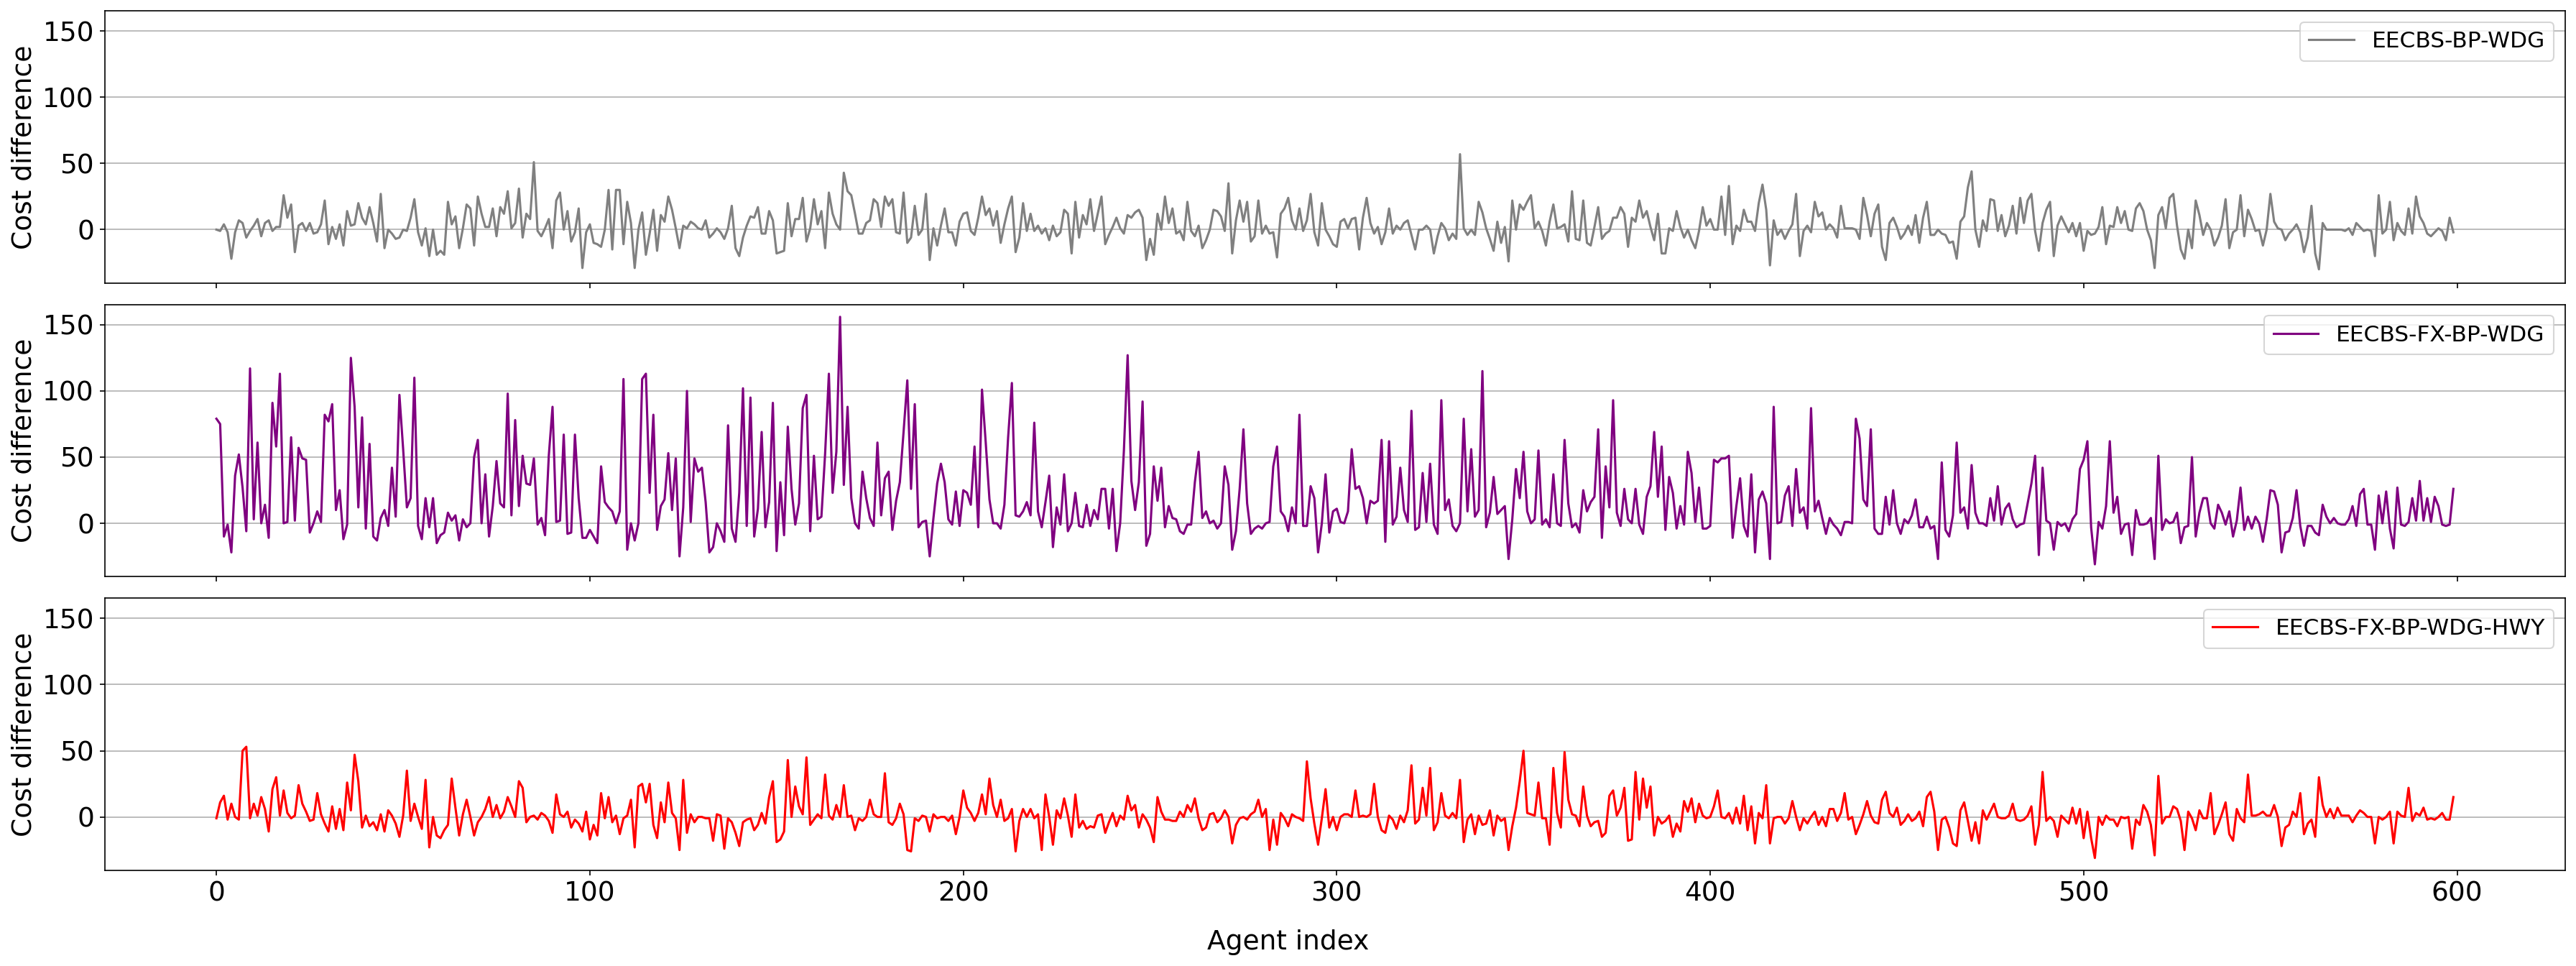

In [42]:
# Plot costs difference with base solver
base_solver:str = "EECBS-BP-WDG-HWY" # "GPBS-1.2"
values:Dict[str,List[int]] = {}
for solver in solvers:
    if solver not in all_paths or solver == base_solver:
        continue
    val = [np.inf for _ in range(max_agent_num)]
    for (ag_id, path) in all_paths[solver]["paths"].items():
        val[ag_id] = all_paths[solver]["paths"][ag_id]["cost"] - \
            all_paths[base_solver]["paths"][ag_id]["cost"]
    values[solver] = val

if len(values) == 0:
    sys.exit("No values involve")

fig, axs = plt.subplots(len(values), figsize=(24,3*len(values)), sharex=True, sharey=True)
for fidx, (solver, val) in enumerate(values.items()):
    if len(values) == 1:
        cur_axs = axs
    else:
        cur_axs = axs[fidx]

    cur_axs.plot(
        list(range(len(val))),
        val,
        label=solver,
        color=solver_colors[solver]
    )
    cur_axs.legend(fontsize=font_size//1.2)
    cur_axs.grid(axis="y")
    cur_axs.tick_params(axis='y', labelsize=font_size)
    cur_axs.set_ylabel("Cost difference", fontsize=font_size)

fig.supxlabel("Agent index", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tight_layout()
plt.show()

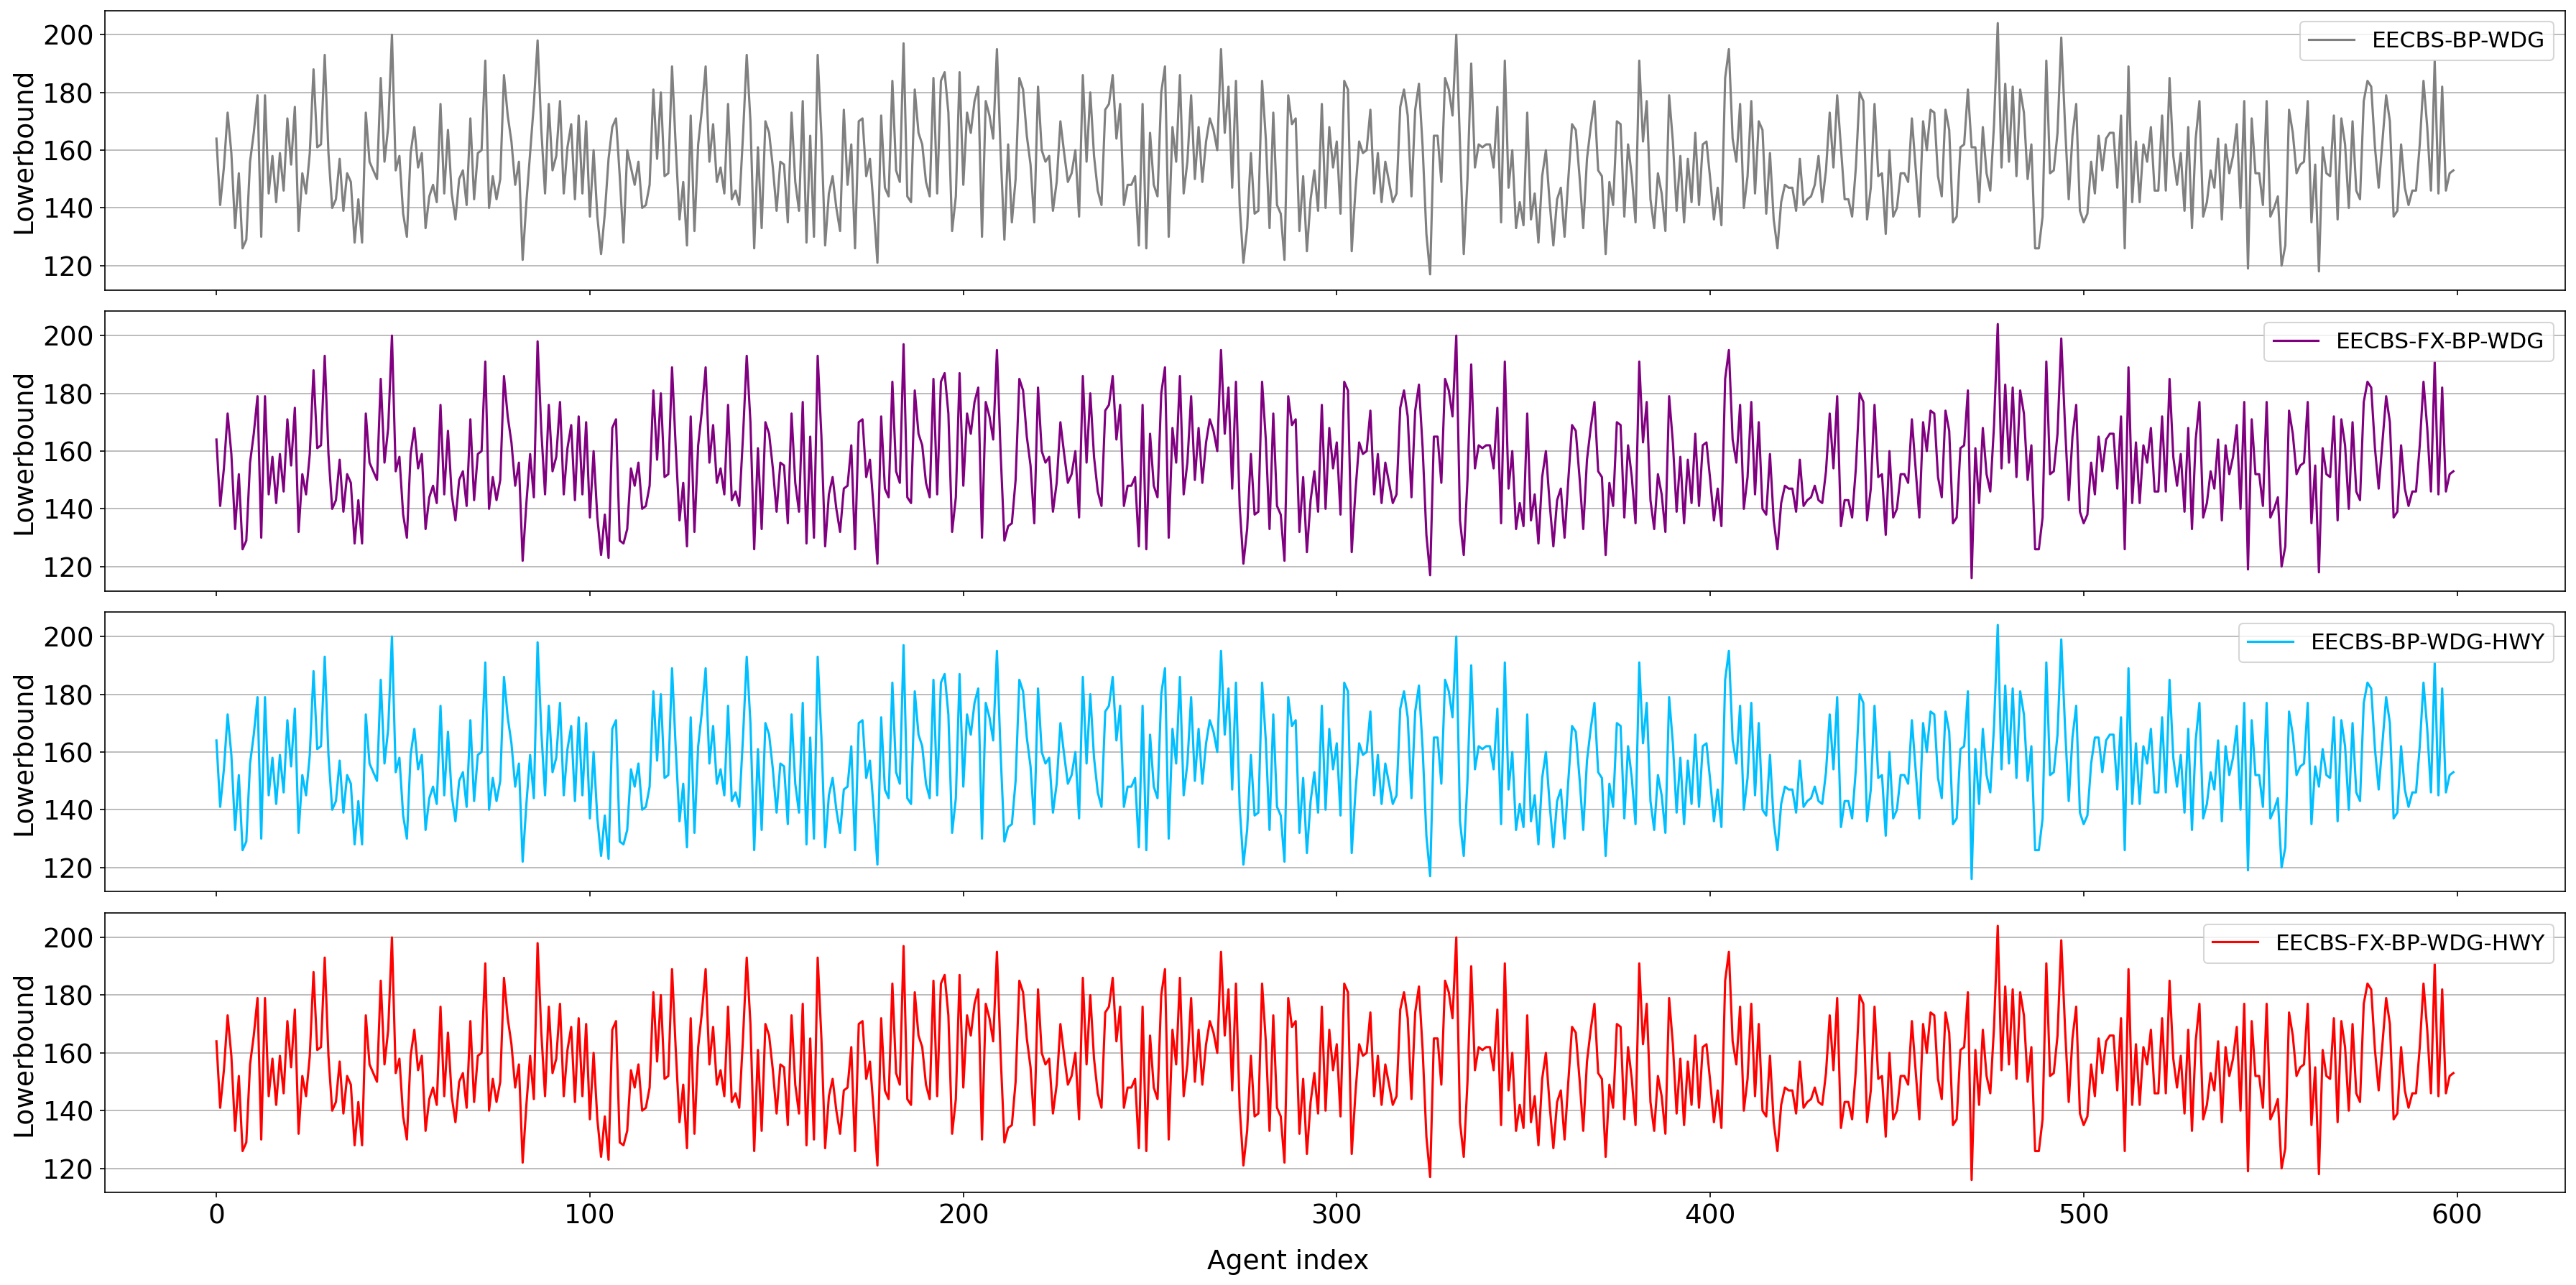

In [43]:
# Plot lowerbounds
values:Dict[str,List[int]] = {}
for solver in solvers:
    if solver not in all_paths or solver in solvers_without_lb:
        continue
    val = [np.inf for _ in range(max_agent_num)]
    for (ag_id, path) in all_paths[solver]["paths"].items():
        val[ag_id] = all_paths[solver]["paths"][ag_id]["lb"]
    values[solver] = val

if len(values) == 0:
    sys.exit("No values involve")

fig, axs = plt.subplots(len(values), figsize=(24,3*len(values)), sharex=True, sharey=True)
for fidx, (solver, val) in enumerate(values.items()):
    if len(values) == 1:
        cur_axs = axs
    else:
        cur_axs = axs[fidx]

    cur_axs.plot(
        list(range(len(val))),
        val,
        label=solver,
        color=solver_colors[solver]
    )

    cur_axs.legend(fontsize=font_size//1.2)
    cur_axs.grid(axis="y")
    cur_axs.tick_params(axis='y', labelsize=font_size)
    cur_axs.set_ylabel("Lowerbound", fontsize=font_size)

fig.supxlabel("Agent index", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tight_layout()
plt.show()

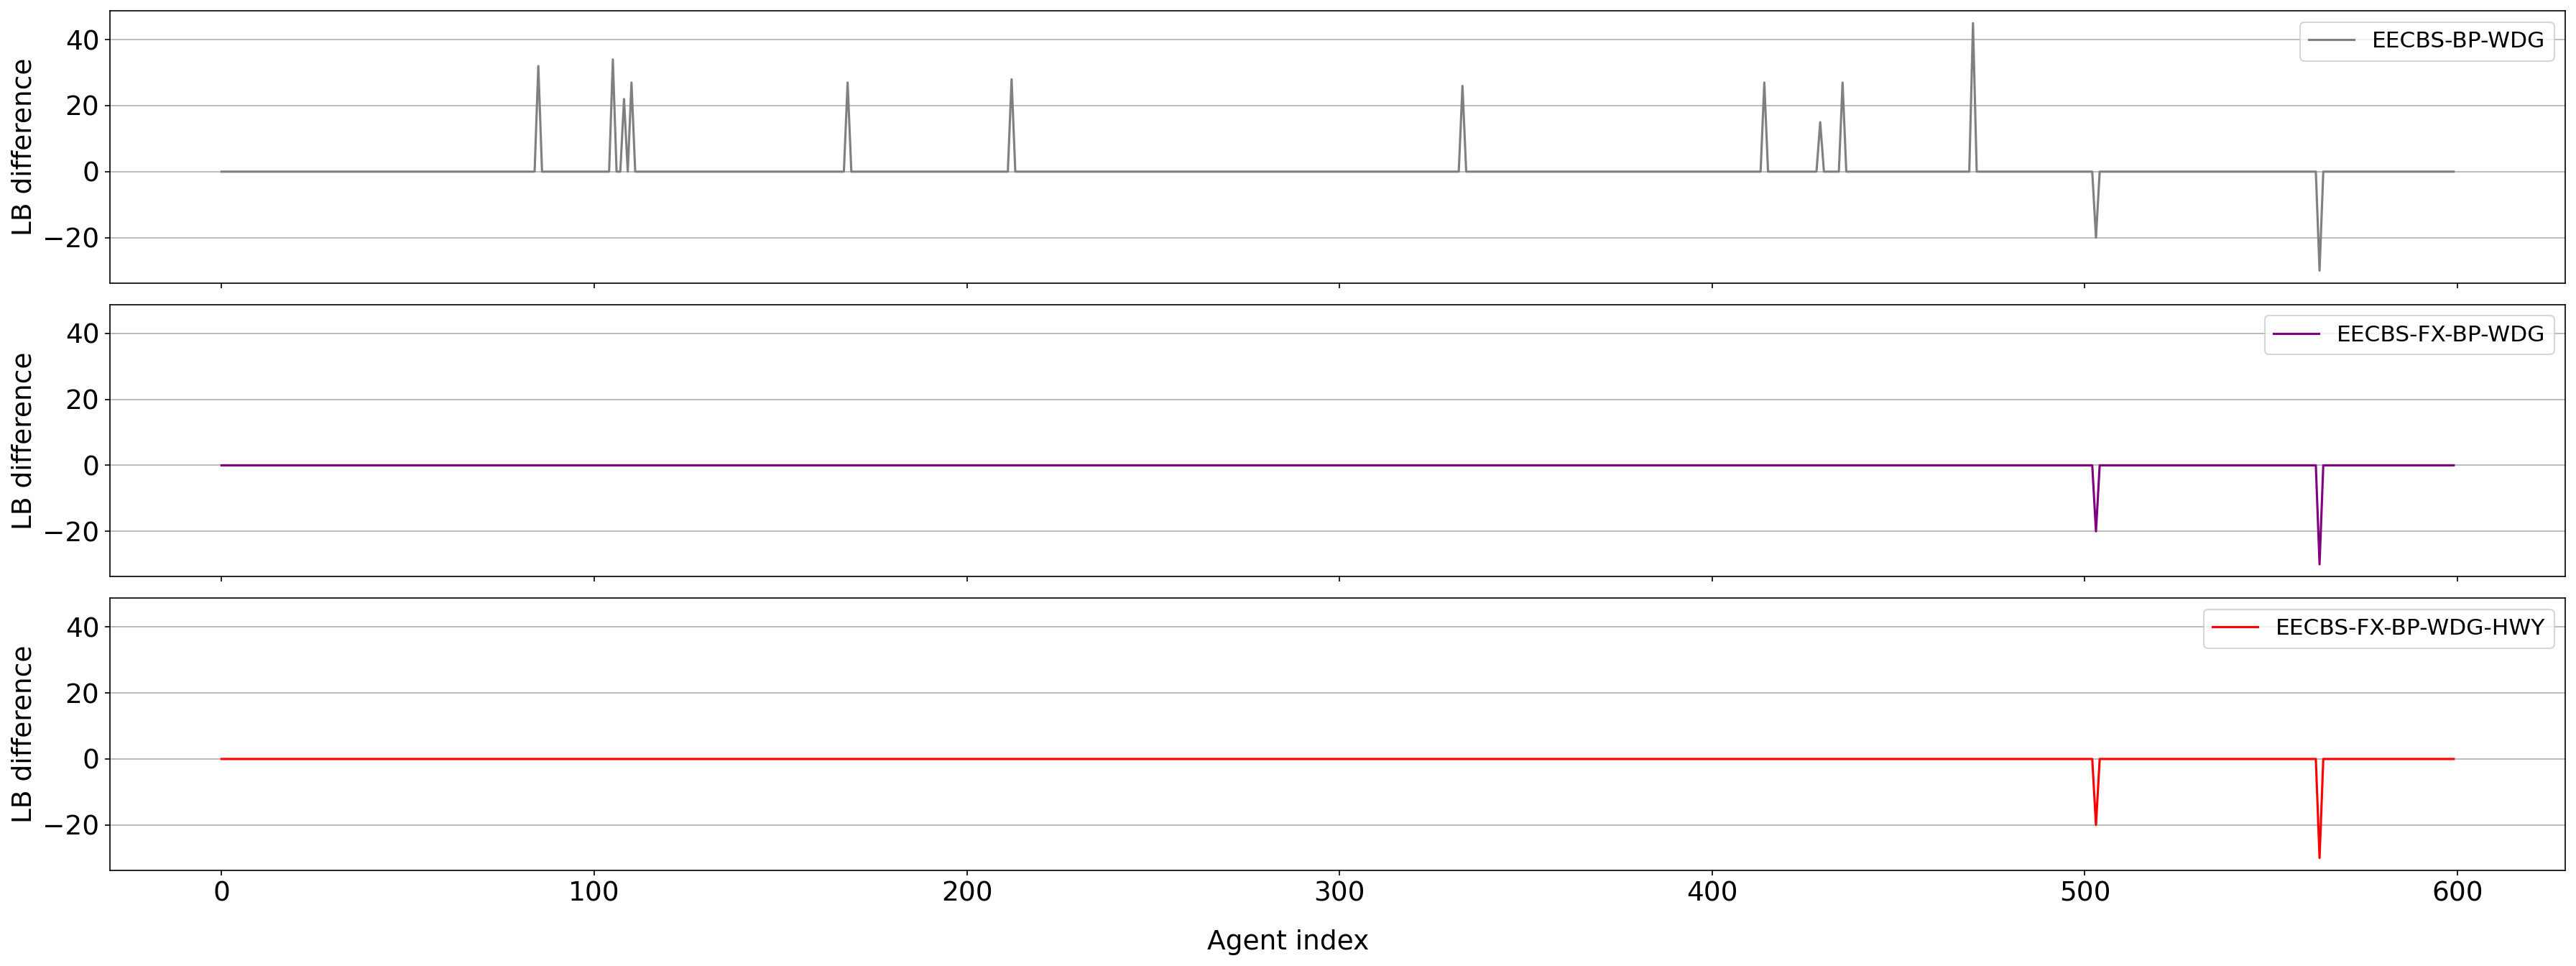

In [44]:
# lowerbound differences with base solver
base_solver:str = "EECBS-BP-WDG-HWY"
values:Dict[str,List[int]] = {}
for solver in solvers:
    if  solver not in all_paths or solver == base_solver or solver in solvers_without_lb:
        continue
    val = [np.inf for _ in range(max_agent_num)]
    for (ag_id, path) in all_paths[solver]["paths"].items():
        val[ag_id] = all_paths[solver]["paths"][ag_id]["lb"] - \
            all_paths[base_solver]["paths"][ag_id]["lb"]
    values[solver] = val

if len(values) == 0:
    sys.exit("No values involve")

fig, axs = plt.subplots(len(values), figsize=(24,3*len(values)), sharex=True, sharey=True)
for fidx, (solver, val) in enumerate(values.items()):
    if len(values) == 1:
        cur_axs = axs
    else:
        cur_axs = axs[fidx]

    cur_axs.plot(
        list(range(len(val))),
        val,
        label=solver,
        color=solver_colors[solver]
    )
    cur_axs.legend(fontsize=font_size//1.2)
    cur_axs.grid(axis="y")
    cur_axs.tick_params(axis='y', labelsize=font_size)
    cur_axs.set_ylabel("LB difference", fontsize=font_size)

fig.supxlabel("Agent index", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tight_layout()
plt.show()

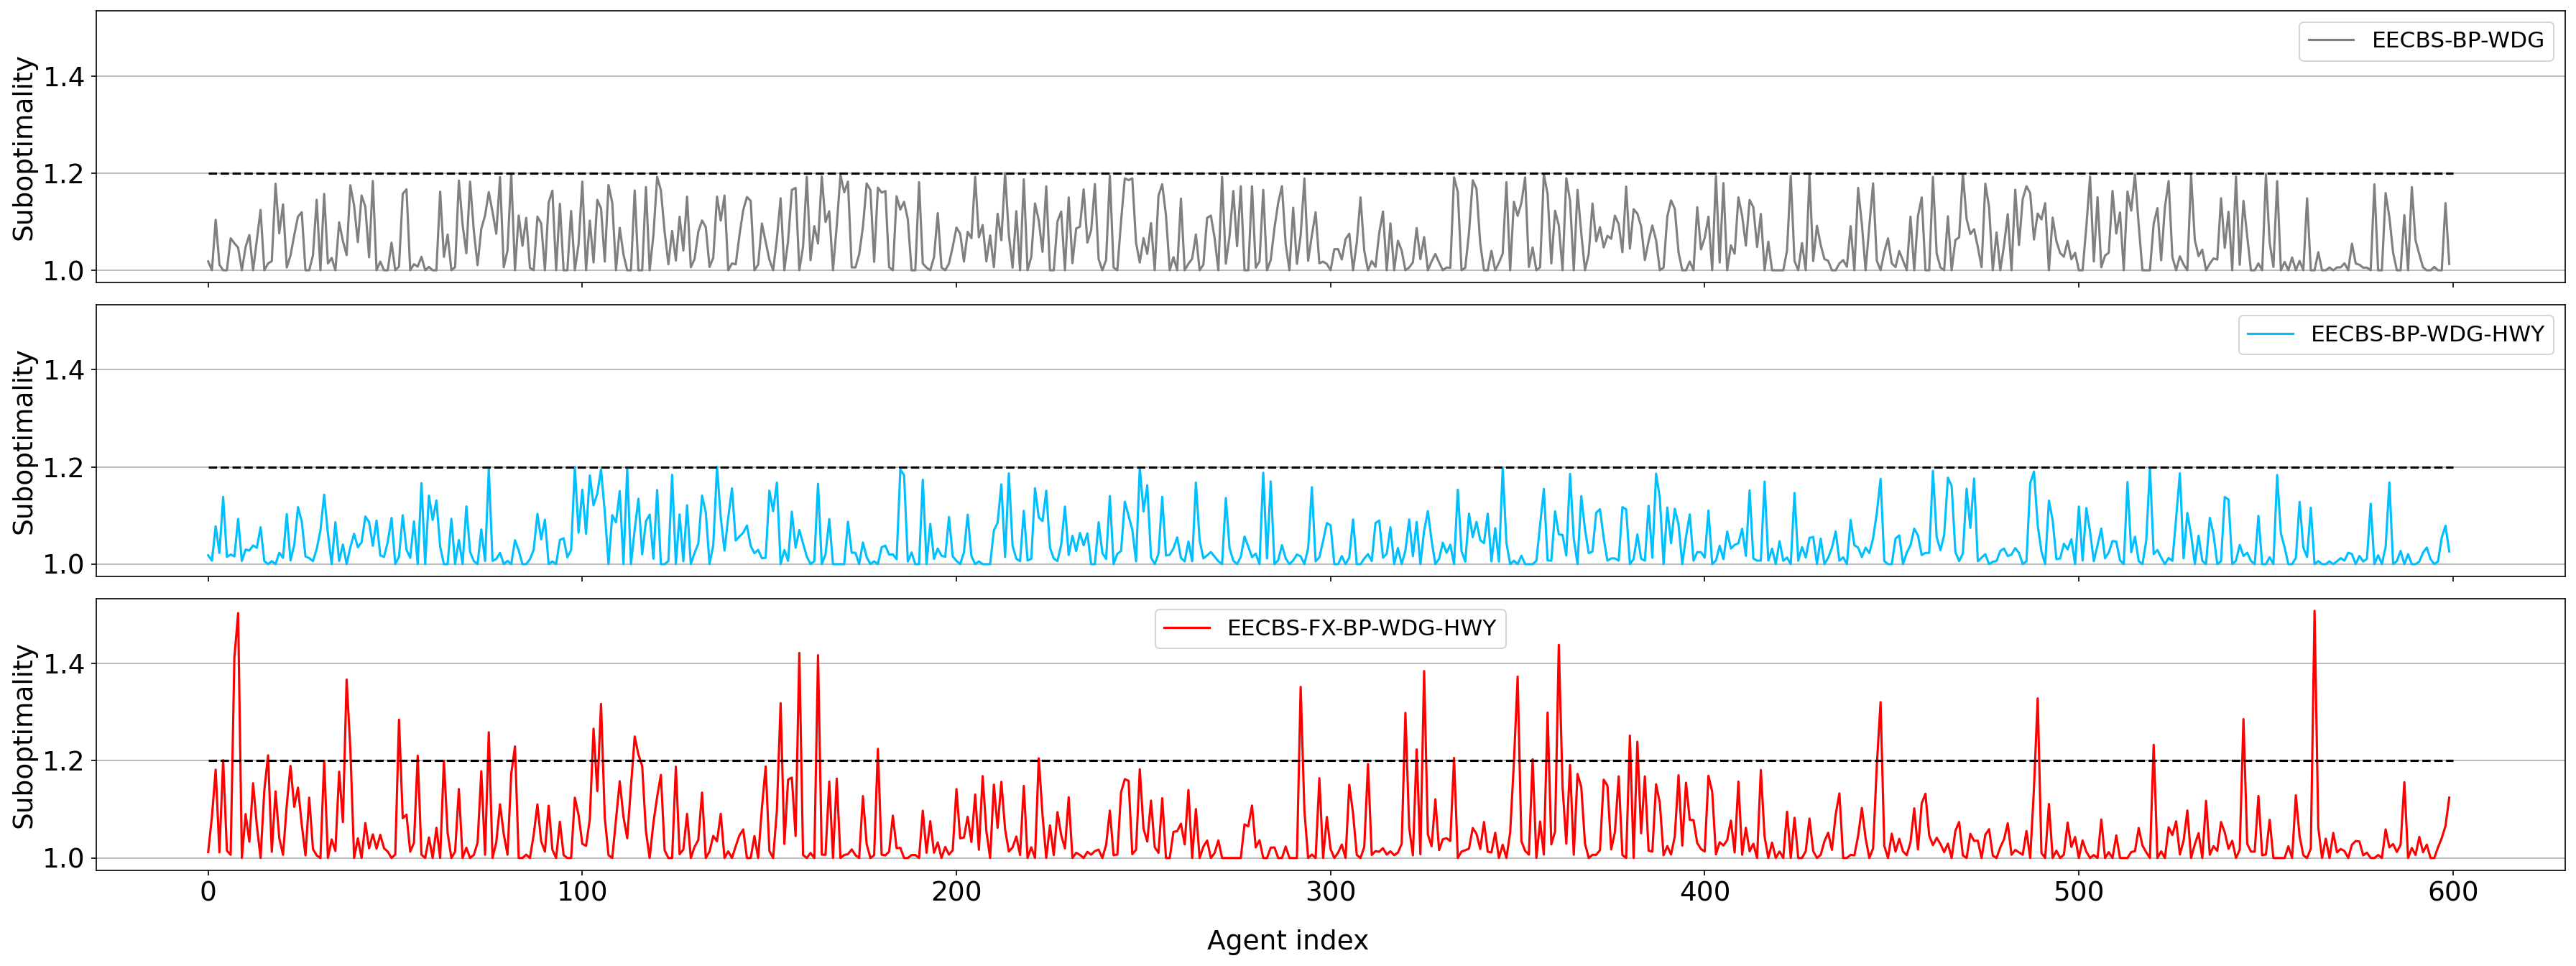

In [46]:
# suboptimality
values:Dict[str,List[int]] = {}
for solver in solvers:
    if solver not in all_paths or solver in solvers_without_lb or solver == "EECBS-FX-BP-WDG":
        continue
    val = [np.inf for _ in range(max_agent_num)]
    for (ag_id, path) in all_paths[solver]["paths"].items():
        val[ag_id] = all_paths[solver]["paths"][ag_id]["cost"] / \
            all_paths[solver]["paths"][ag_id]["lb"]
    values[solver] = val

if len(values) == 0:
    sys.exit("No values involve")

fig, axs = plt.subplots(len(values), figsize=(24,3*len(values)), sharex=True, sharey=True)
for fidx, (solver, val) in enumerate(values.items()):
    if len(values) == 1:
        cur_axs = axs
    else:
        cur_axs = axs[fidx]

    cur_axs.plot(
        list(range(len(val))),
        val,
        label=solver,
        color=solver_colors[solver]
    )
    cur_axs.hlines(y=1.2, xmin=0, xmax=len(val), color="black", linestyle='--')
    cur_axs.legend(fontsize=font_size//1.2)
    cur_axs.grid(axis="y")
    cur_axs.tick_params(axis='y', labelsize=font_size)
    cur_axs.set_ylabel("Suboptimality", fontsize=font_size)

fig.supxlabel("Agent index", fontsize=font_size)
plt.xticks(fontsize=font_size)
plt.tight_layout()
plt.show()